In [85]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
# Cargar el archivo
data = np.load("df-deepfake.npz")

# Acceder a los arrays
X = data['X']
y = data['y']
uuids = data['uuids']


Forma1

In [125]:
from sklearn.model_selection import train_test_split

# Primer split: 80% Train+Val, 20% Test
X_train_val, X_test, y_train_val, y_test, uuids_train_val, uuids_test = train_test_split(
    X, y, uuids, test_size=0.05, random_state=42, stratify=y
)

# Segundo split: 75% Train, 25% Validación dentro del 80% que quedó
X_train, X_val, y_train, y_val, uuids_train, uuids_val = train_test_split(
    X_train_val, y_train_val, uuids_train_val, test_size=0.1, random_state=42, stratify=y_train_val
)


In [118]:
print(X_train.shape)

(115, 30)


Forma 2

In [119]:
# Conteo de clases
unique, counts = np.unique(y_train, return_counts=True)
print("Conteo de clases en y_train:")
for cls, cnt in zip(unique, counts):
    print(f"Clase {cls}: {cnt} muestras")

# Conteo de clases
unique, counts = np.unique(y_val, return_counts=True)
print("Conteo de clases en y_val:")
for cls, cnt in zip(unique, counts):
    print(f"Clase {cls}: {cnt} muestras")

# Conteo de clases
unique, counts = np.unique(y_test, return_counts=True)
print("Conteo de clases en y_test:")
for cls, cnt in zip(unique, counts):
    print(f"Clase {cls}: {cnt} muestras")

Conteo de clases en y_train:
Clase 0: 53 muestras
Clase 1: 62 muestras
Conteo de clases en y_val:
Clase 0: 3 muestras
Clase 1: 4 muestras
Conteo de clases en y_test:
Clase 0: 3 muestras
Clase 1: 4 muestras


Logistic Regression

In [120]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import GroupKFold
import numpy as np

# GroupKFold
gkf = GroupKFold(n_splits=5)


# Escalar manualmente
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_train)



# Modelo base
lr = LogisticRegression(max_iter=1000)

# Definir grilla de hiperparámetros
param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],             # Regularización
    'solver': ['lbfgs', 'liblinear'],         # Algoritmos
    'penalty': ['l2']                         # Tipo de penalización (solo 'l2' es compatible con lbfgs y liblinear)
}

# Métricas para evaluar
scoring = {
    'accuracy': 'accuracy',
    'recall': 'recall',
    'f1': 'f1'
}

grid = GridSearchCV(estimator=lr, param_grid=param_grid, cv=gkf,
                    scoring=scoring, refit='f1', return_train_score=False)

# Entrenar
grid.fit(X_scaled, y_train, groups=groups_train)

# Resultados
print("🔍 Mejor combinación de hiperparámetros:", grid.best_params_)
print(f"📈 Mejor F1-score (CV): {grid.best_score_:.4f}")

# Puedes imprimir más métricas si deseas:
means = grid.cv_results_
print(f"✅ Accuracy medio: {means['mean_test_accuracy'][grid.best_index_]:.4f}")
print(f"✅ Recall medio:   {means['mean_test_recall'][grid.best_index_]:.4f}")


ValueError: Found input variables with inconsistent numbers of samples: [115, 115, 118]

In [91]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report
from sklearn.feature_selection import SelectKBest, f_classif
import numpy as np


# 2. Escalado y selección de características
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)




# 4. Modelo con ajuste fino
lr = LogisticRegression(
    C=0.1,                   # Mayor regularización
    penalty='l2',
    solver='liblinear',
    max_iter=1000,           # Más iteraciones para convergencia
    random_state=42
)

# 5. Entrenamiento y evaluación
lr.fit(X_train_scaled, y_train)

print("🔹 Evaluación en TRAIN:")
print(classification_report(y_train, lr.predict(X_train_scaled), target_names=["Real", "Fake"]))

print("\n🔹 Evaluación en VALIDACIÓN:")
y_pred_val = lr.predict(X_val_scaled)
print(classification_report(y_val, y_pred_val, target_names=["Real", "Fake"]))


🔹 Evaluación en TRAIN:
              precision    recall  f1-score   support

        Real       0.63      0.51      0.56        53
        Fake       0.61      0.72      0.66        57

    accuracy                           0.62       110
   macro avg       0.62      0.61      0.61       110
weighted avg       0.62      0.62      0.61       110


🔹 Evaluación en VALIDACIÓN:
              precision    recall  f1-score   support

        Real       0.00      0.00      0.00         3
        Fake       0.62      0.56      0.59         9

    accuracy                           0.42        12
   macro avg       0.31      0.28      0.29        12
weighted avg       0.47      0.42      0.44        12



Knn Neighbors

In [110]:
from sklearn.model_selection import GridSearchCV, LeaveOneOut
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
import numpy as np

# Leave-One-Out
loo = LeaveOneOut()

# Escalar
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_train)

# Modelo base
knn = KNeighborsClassifier()

# Grilla de hiperparámetros
param_grid = {
    'n_neighbors': [5, 10, 15],
    'weights': ['uniform'],
    'metric': ['euclidean', 'manhattan']
}

# Scoring múltiple
scoring = {
    'accuracy': 'accuracy',
    'recall': 'recall',
    'f1': 'f1'
}

# GridSearch con LOO
grid = GridSearchCV(
    estimator=knn,
    param_grid=param_grid,
    scoring=scoring,
    refit='f1',  # el mejor se elige por f1
    cv=loo,
    n_jobs=-1,
    verbose=1
)

# Entrenar
grid.fit(X_scaled, y_train)

# Resultados
print("🔍 Mejor combinación de hiperparámetros:", grid.best_params_)
print(f"📈 Mejor F1-score (CV): {grid.cv_results_['mean_test_f1'][grid.best_index_]:.4f}")
print(f"✅ Accuracy medio:       {grid.cv_results_['mean_test_accuracy'][grid.best_index_]:.4f}")
print(f"✅ Recall medio:         {grid.cv_results_['mean_test_recall'][grid.best_index_]:.4f}")


Fitting 118 folds for each of 6 candidates, totalling 708 fits
🔍 Mejor combinación de hiperparámetros: {'metric': 'manhattan', 'n_neighbors': 15, 'weights': 'uniform'}
📈 Mejor F1-score (CV): 0.3729
✅ Accuracy medio:       0.5847
✅ Recall medio:         0.3729


In [121]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import VarianceThreshold, SelectKBest, f_classif
from sklearn.metrics import classification_report
import numpy as np


# 2. Escalado
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)



# 4. Entrenar KNN (configuración original)
knn = KNeighborsClassifier(
    n_neighbors=5,
    weights='uniform',
    metric='manhattan'
)
knn.fit(X_train_scaled, y_train)

# 5. Evaluación
print("🔹 Evaluación en TRAIN:")
print(classification_report(y_train, knn.predict(X_train_scaled)))

print("\n🔹 Evaluación en VALIDACIÓN:")
print(classification_report(y_val, knn.predict(X_val_scaled)))


🔹 Evaluación en TRAIN:
              precision    recall  f1-score   support

           0       0.69      0.70      0.69        53
           1       0.74      0.73      0.73        62

    accuracy                           0.71       115
   macro avg       0.71      0.71      0.71       115
weighted avg       0.71      0.71      0.71       115


🔹 Evaluación en VALIDACIÓN:
              precision    recall  f1-score   support

           0       0.33      0.33      0.33         3
           1       0.50      0.50      0.50         4

    accuracy                           0.43         7
   macro avg       0.42      0.42      0.42         7
weighted avg       0.43      0.43      0.43         7



Random Forest

In [112]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
import numpy as np

# GroupKFold
gkf = GroupKFold(n_splits=5)



# Escalar
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_train)

# Definir modelo base
rf = RandomForestClassifier(random_state=42)

# Definir la grilla de hiperparámetros
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [5, 10, 15],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

scoring = {
    'accuracy': 'accuracy',
    'recall': 'recall',
    'f1': 'f1'
}

# Crear GridSearchCV
grid = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    scoring=scoring,  # también puedes usar 'recall' si priorizas eso
    cv=gkf,
    refit='f1',  # el mejor se elige por f1
    n_jobs=-1,
    verbose=1
)

# Ejecutar búsqueda
grid.fit(X_scaled, y_train, groups=groups_train)

# Resultados
print("🔍 Mejor combinación de hiperparámetros:", grid.best_params_)
print(f"📈 Mejor F1-score (CV): {grid.cv_results_['mean_test_f1'][grid.best_index_]:.4f}")
print(f"✅ Accuracy medio:       {grid.cv_results_['mean_test_accuracy'][grid.best_index_]:.4f}")
print(f"✅ Recall medio:         {grid.cv_results_['mean_test_recall'][grid.best_index_]:.4f}")

Fitting 5 folds for each of 24 candidates, totalling 120 fits
🔍 Mejor combinación de hiperparámetros: {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
📈 Mejor F1-score (CV): 0.6423
✅ Accuracy medio:       0.5764
✅ Recall medio:         0.6905


In [128]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report
import numpy as np



# 2. Escalar los datos
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

# 3. Crear y entrenar modelo
rf = RandomForestClassifier(max_depth= 5, min_samples_leaf= 1, min_samples_split= 2, n_estimators = 200, random_state=42)
rf.fit(X_train_scaled, y_train)

# 4. Evaluar en entrenamiento y validación
print("🔹 Evaluación en TRAIN:")
print(classification_report(y_train, rf.predict(X_train_scaled)))

print("🔹 Evaluación en VALIDACIÓN:")
print(classification_report(y_val, rf.predict(X_val_scaled)))


🔹 Evaluación en TRAIN:
              precision    recall  f1-score   support

           0       0.97      0.84      0.90       735
           1       0.89      0.98      0.93       960

    accuracy                           0.92      1695
   macro avg       0.93      0.91      0.92      1695
weighted avg       0.93      0.92      0.92      1695

🔹 Evaluación en VALIDACIÓN:
              precision    recall  f1-score   support

           0       0.42      0.35      0.38       240
           1       0.63      0.70      0.66       375

    accuracy                           0.56       615
   macro avg       0.52      0.52      0.52       615
weighted avg       0.55      0.56      0.55       615



SVM

In [97]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
import numpy as np

# GroupKFold
gkf = GroupKFold(n_splits=5)

# Escalar datos
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_train)

# Definir modelo
svm = SVC(random_state=42)

# Grilla de hiperparámetros
param_grid = {
        'kernel': ['linear','rbf', 'poly' ],
        'C': [0.1, 1, 10],
        'degree': [2, 3],
        'gamma': ['scale', 0.01, 0.1]
    }

# Métricas
scoring = {
    'accuracy': 'accuracy',
    'recall': 'recall',
    'f1': 'f1'
}

# GridSearchCV
grid = GridSearchCV(
    estimator=svm,
    param_grid=param_grid,
    scoring=scoring,
    refit='f1',
    cv=gkf,
    n_jobs=-1,
    verbose=1
)

# Ajustar
grid.fit(X_scaled, y_train, groups=groups_train)

# Resultados
print("🔍 Mejor combinación de hiperparámetros:", grid.best_params_)
print(f"📈 Mejor F1-score (CV): {grid.cv_results_['mean_test_f1'][grid.best_index_]:.4f}")
print(f"✅ Accuracy medio:       {grid.cv_results_['mean_test_accuracy'][grid.best_index_]:.4f}")
print(f"✅ Recall medio:         {grid.cv_results_['mean_test_recall'][grid.best_index_]:.4f}")


Fitting 5 folds for each of 54 candidates, totalling 270 fits
🔍 Mejor combinación de hiperparámetros: {'C': 10, 'degree': 2, 'gamma': 'scale', 'kernel': 'linear'}
📈 Mejor F1-score (CV): 0.6248
✅ Accuracy medio:       0.5909
✅ Recall medio:         0.6491


In [127]:
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report
import numpy as np

# Cargar datos
data = np.load("deepfake_dataset_splits.npz")
X_train = data['X_train']
y_train = data['y_train']

X_val = data['X_val']
y_val = data['y_val']

# 2. Escalar los datos
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)


# 3. Crear y entrenar modelo
svm = SVC(C=0.1, kernel='rbf', gamma='scale', degree = 2, class_weight='balanced', random_state=42)
svm.fit(X_train_scaled, y_train)

# 4. Evaluar en entrenamiento y validación
print("🔹 Evaluación en TRAIN:")
print(classification_report(y_train, svm.predict(X_train_scaled)))

print("🔹 Evaluación en VALIDACIÓN:")
print(classification_report(y_val, svm.predict(X_val_scaled)))


🔹 Evaluación en TRAIN:
              precision    recall  f1-score   support

           0       0.85      0.84      0.85       735
           1       0.88      0.89      0.89       960

    accuracy                           0.87      1695
   macro avg       0.87      0.87      0.87      1695
weighted avg       0.87      0.87      0.87      1695

🔹 Evaluación en VALIDACIÓN:
              precision    recall  f1-score   support

           0       0.40      0.43      0.41       240
           1       0.61      0.58      0.60       375

    accuracy                           0.52       615
   macro avg       0.51      0.51      0.50       615
weighted avg       0.53      0.52      0.52       615



Neural Network

In [126]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report
from sklearn.feature_selection import SelectKBest, f_classif
import numpy as np

# ----------------- 1. Escalado ----------------- #
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

# ----------------- 2. Selección de Features ----------------- #
k = 10
selector = SelectKBest(f_classif, k=k)
X_train_selected = selector.fit_transform(X_train_scaled, y_train)
X_val_selected = selector.transform(X_val_scaled)

# ----------------- 3. Preparar tensores ----------------- #
X_train_tensor = torch.tensor(X_train_selected, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.reshape(-1, 1), dtype=torch.float32)

X_val_tensor = torch.tensor(X_val_selected, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val.reshape(-1, 1), dtype=torch.float32)

# ----------------- 4. Definir Red Neuronal ----------------- #
class SimpleNN(nn.Module):
    def __init__(self, input_size, hidden_size=32):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, 1)
    
    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x  # Sin activación final, usamos BCEWithLogitsLoss

# Ojo aquí: input_size debe ser el número de columnas después del SelectKBest
model = SimpleNN(input_size=X_train_selected.shape[1], hidden_size=32)

# ----------------- 5. Configuración ----------------- #
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# ----------------- 6. Entrenamiento ----------------- #
epochs = 100
for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()
    outputs = model(X_train_tensor)
    loss = criterion(outputs, y_train_tensor)
    loss.backward()
    optimizer.step()

# ----------------- 7. Evaluación ----------------- #
model.eval()
with torch.no_grad():
    outputs_train = model(X_train_tensor)
    probs_train = torch.sigmoid(outputs_train).numpy()
    y_pred_train = (probs_train > 0.5).astype(int).flatten()

    outputs_val = model(X_val_tensor)
    probs_val = torch.sigmoid(outputs_val).numpy()
    y_pred_val = (probs_val > 0.5).astype(int).flatten()

print("🔹 Evaluación en TRAIN:")
print(classification_report(y_train, y_pred_train))

print("\n🔹 Evaluación en VALIDACIÓN:")
print(classification_report(y_val, y_pred_val))


🔹 Evaluación en TRAIN:
              precision    recall  f1-score   support

           0       0.69      0.40      0.51        50
           1       0.62      0.85      0.72        59

    accuracy                           0.64       109
   macro avg       0.66      0.62      0.61       109
weighted avg       0.65      0.64      0.62       109


🔹 Evaluación en VALIDACIÓN:
              precision    recall  f1-score   support

           0       0.50      0.33      0.40         6
           1       0.56      0.71      0.62         7

    accuracy                           0.54        13
   macro avg       0.53      0.52      0.51        13
weighted avg       0.53      0.54      0.52        13



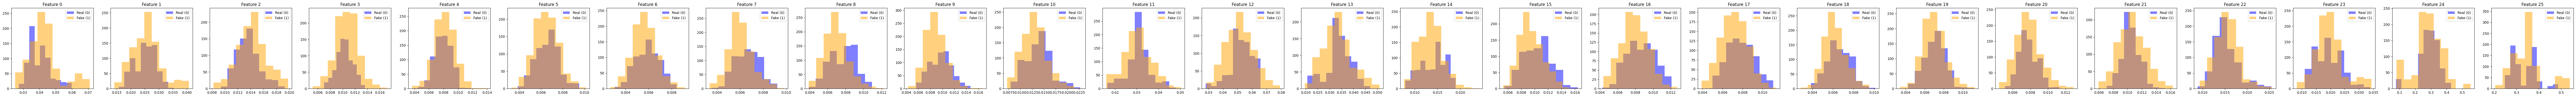

In [79]:
import matplotlib.pyplot as plt

num_features = 26  # Número de features que quieres visualizar (puedes cambiarlo)
fig, axes = plt.subplots(1, num_features, figsize=(4 * num_features, 4))

for i in range(num_features):
    axes[i].hist(X_train[y_train == 0][:, i], alpha=0.5, label='Real (0)', color='blue')
    axes[i].hist(X_train[y_train == 1][:, i], alpha=0.5, label='Fake (1)', color='orange')
    axes[i].set_title(f'Feature {i}')
    axes[i].legend()

plt.tight_layout()
plt.show()
